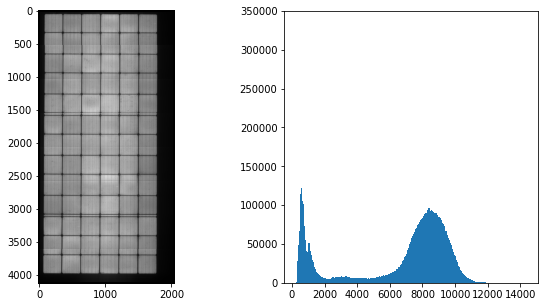

In [11]:
''' Creation: 2021.09.26
    Last update: 2021.10.01
    
    Electroluminecence greateyes raw images reading and plotting 
    
    '''

# Standard library import
import os.path
from pathlib import Path

# 3rd party imports
import matplotlib.pyplot as plt
import numpy as np

#Internal import 
import PVcharacterization_Utils as pv

file_names = ["SERAPHIM-EM-0640_Isc_ap500hXDH.dat",
              "JINERGY3272023326035_Isc_T2.dat",
              "JINERGY3272023326035_Isc_T1.dat",
              "EL_Komma_Problem.dat"
              ]

file_name = file_names[1]

file = pv.GLOBAL['WORKING_DIR_EL'] / Path(file_name)

borne_sup = np.Inf
borne_inf = 800
filter_image = False

electrolum = pv.read_electolum_file(file,pack=True)

if len(electrolum.image) > 1:
    fig = plt.figure(figsize=(16,12))
    gs = fig.add_gridspec(7,2, hspace=0.5, wspace=0)
    axe = gs.subplots(sharex='col')
    for index, image in enumerate(electrolum.image):
        #if index == 6 : break
        
        if filter_image : image = np.where((image < borne_inf) | ( image > borne_sup), 0, image)
            

        axe[index,0].imshow(image,
                   cmap='gray', 
                   interpolation=None)
        for axis in ['top','bottom','left','right']:
            axe[index,0].spines[axis].set_linewidth(0)
        
        image_flatten = image.flatten()
        if filter_image :image_flatten = image_flatten[image_flatten != 0]
        _ = axe[index,1].hist(image_flatten, bins='auto')
        axe[index,1].set_ylim([0,50000])
        
        file_gsf = os.path.splitext(file_name)[0] + '_' + str(index+1) + '.gsf'
        file = pv.GLOBAL['WORKING_DIR_EL'] / Path(file_gsf)
        pv.py2gwyddion(image, file)
        

else: # Full image treatment
    fig,axe = plt.subplots(1,2,figsize=(10,5))
    for index, image in enumerate(electrolum.image):
        if filter_image : image = np.where((image < borne_inf) | ( image > borne_sup), 0, image)
        axe[0].imshow(image,
                   cmap='gray', 
                   interpolation=None)
        for axis in ['top','bottom','left','right']:
            axe[0].spines[axis].set_linewidth(2)
            
        image_flatten = image.flatten()
        if filter_image : image_flatten = image_flatten[image_flatten != 0]
        
        _ = axe[1].hist(image.flatten(), bins='auto')
        axe[1].set_ylim([0,7*50000])
    
        file_gsf = os.path.splitext(file_name)[0] + '.gsf'
        file = pv.GLOBAL['WORKING_DIR_EL'] / Path(file_gsf)
        pv.py2gwyddion(image, file)
plt.show()

In [ ]:
from skimage.transform import hough_transform

image = electrolum.image[2]

fig = plt.figure()
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Input image')

h, theta, d = hough_transform.hough_line(image)
fig = plt.figure()
plt.imshow(np.log(1 + h),
           extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
                   d[-1], d[0]],
           cmap=plt.cm.gray, aspect=1/1.5)
plt.title('Hough transform')
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')

fig = plt.figure()
plt.imshow(image, cmap=plt.cm.gray)
rows, cols = image.shape
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    plt.plot((0, cols), (y0, y1), '-r')
plt.axis((0, cols, rows, 0))
plt.title('Detected lines')


In [ ]:
from skimage.transform.hough_transform import hough_line, hough_line_peaks
from skimage import data

import numpy as np
import matplotlib.pyplot as plt

# Construct test image

image = np.zeros((100, 100))


# Classic straight-line Hough transform

idx = np.arange(25, 75)
image[idx[::-1], idx] = 255
image[idx, idx] = 255

h, theta, d = hough_line(image)

plt.figure(figsize=(8, 4))

plt.subplot(131)
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Input image')

plt.subplot(132)
plt.imshow(np.log(1 + h),
           extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
                   d[-1], d[0]],
           cmap=plt.cm.gray, aspect=1/1.5)
plt.title('Hough transform')
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')

plt.subplot(133)
plt.imshow(image, cmap=plt.cm.gray)
rows, cols = image.shape
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    plt.plot((0, cols), (y0, y1), '-r')
plt.axis((0, cols, rows, 0))
plt.title('Detected lines')


In [ ]:
''' Creation: 2021.09.26
    Last update: 2021.10.04
    
    Electroluminecence greateyes raw images reading, croping and plotting 
    
    '''

# Standard library import
import os
from pathlib import Path

# 3rd party imports
import matplotlib.pyplot as plt

#Internal import 
import PVcharacterization_Utils as pv


NCOLS_SUPPRESS = 10 # Number of columns supressed for the image plotting

# Reads, crops and stitches the set of electroluminesence images acquired with greateyes camera
file_names = ["SERAPHIM-EM-0640_Isc_ap500hXDH.dat",
              "JINERGY3272023326035_Isc_T2.dat",
              "JINERGY3272023326035_Isc_T1.dat",
              "EL_Komma_Problem.dat"
              ]
file_name = file_names[3]

file = pv.GLOBAL['WORKING_DIR_EL'] / Path(file_name)

croped_image = pv.crop_image(file)

# Plots the image throwing away the NCOLS_SUPPRESS first columns
fig,axe = plt.subplots(1,1,figsize=(15,15))
axe.imshow(croped_image[:,NCOLS_SUPPRESS:],
           cmap='gray', 
           interpolation=None)
for axis in ['top','bottom','left','right']:
            axe.spines[axis].set_linewidth(0)
axe.set_xticklabels([])
axe.set_yticklabels([])
axe.set_xticks([])
axe.set_yticks([])
plt.title(file_name)

# Dumps the image in Gwyddion Simple Field Files format
file_gsf = os.path.splitext(file_name)[0] + '_full.gsf'
file = pv.GLOBAL['WORKING_DIR_EL'] / Path(file_gsf)
pv.py2gwyddion(croped_image, file) 

In [ ]:
from skimage.transform import hough_transform

image = croped_image

fig = plt.figure()
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Input image')

h, theta, d = hough_transform.hough_line(image)
fig = plt.figure()
plt.imshow(np.log(1 + h),
           extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
                   d[-1], d[0]],
           cmap=plt.cm.gray, aspect=1/1.5)
plt.title('Hough transform')
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')

fig = plt.figure()
plt.imshow(image, cmap=plt.cm.gray)
rows, cols = image.shape
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    plt.plot((0, cols), (y0, y1), '-r')
plt.axis((0, cols, rows, 0))
plt.title('Detected lines')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.util import random_noise
from skimage import feature


# Generate noisy image of a square
image = np.zeros((128, 128), dtype=float)
image[32:-32, 32:-32] = 1

image = ndi.rotate(image, 15, mode='constant')
image = ndi.gaussian_filter(image, 4)
image = random_noise(image, mode='speckle', mean=100)

image = croped_image

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(image)
edges2 = feature.canny(image, sigma=100)

# display results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('noisy image', fontsize=20)

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon May 23 10:18:47 2022

@author: GR270188

This is a script to deal with EL images, it can plot all the images with the same scale
and also do auto cropping of the images if option is activated
put all raw tif 16 bit images in the same folder and select it throught the pop up window
"""
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import os
import cv2#pip install opencv-python
import tkinter
from tkinter.filedialog import askopenfilename, askdirectory
import datetime
from tqdm import tqdm
import scipy.signal
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# option ######################################################################
option_scale = []#[min,max] or [] specify scale limits i.e. [0,35000]
option_color = 'plasma'#'plasma','viridis','gray','inferno','turbo', etc.. type matplotlib.cm.get_cmap('abcd') in the console for full list
option_autocrop = "y"# "y" / "n"
option_autocrop_para = [7,4,7,4,5]
"""
[2D SG window_size (must be odd),
 2D SG order,
 laplacian kernel size,
 laplacian kernel sigma,
 fraction of the std laplacian taken into account for the module edge detection]
"""
#dirbase = 'H:/Python Scripts/EL'
dirbase = 'S:/370-Energie/370.67-Projets_INES/370.67.546-21-00708_TRIDENT/60-Document Travail/60.3-Etudes'

# data and res folder #########################################################
rooot = tkinter.Tk()
rooot.geometry('+200+200')
rooot.attributes("-topmost", True)
rooot.withdraw()
rooot.lift()

data_folder = askdirectory(parent=rooot, title="Folder of all images",initialdir=dirbase)
pres=os.path.splitext(data_folder)[0]+'/EL '+datetime.datetime.now().strftime("%y-%m-%d %Hh%M")
os.mkdir(pres)

# open images #################################################################
file_fig = [f for f in glob.glob(data_folder+'/' + "**.tif", recursive=False)]
list_fig_name = [os.path.splitext(os.path.basename(f))[0] for f in file_fig]
list_im = []

print("importing images")
for i in tqdm(range(len(file_fig))):
    list_im.append(cv2.imread(file_fig[i],cv2.IMREAD_UNCHANGED))

dim_im = np.array([f.shape for f in list_im])

Cmax=0
for i in range(len(list_im)):
    list_im[i]=list_im[i][::-1,:]
    Cmax = np.amax([Cmax,list_im[i].max()])

print("saving images")
cmap = matplotlib.cm.get_cmap(option_color).copy()
cmap.set_over('green')
cmap.set_under('green')
plt.ioff()
gs = matplotlib.gridspec.GridSpec(1, 1)
if len(option_scale)==2:
    print("using "+ str(option_scale[0])+" to "+str(option_scale[1]) +" as color scale")
    c_scale = option_scale
    if option_scale[1]<Cmax:
        print("WARNING: max color scale is "+str(option_scale[1]) +" but max data is "+str(Cmax) +" some pixels will be out of scale")
    
else:
    c_scale = [0,Cmax]

for i in tqdm(range(len(file_fig))):
    fig10 = plt.figure(10,figsize=(dim_im[i,1]/400, dim_im[i,0]/400))
    ax10 = fig10.add_subplot(gs[0, 0])
    ax10.imshow(list_im[i],cmap=cmap,vmin=c_scale[0],vmax=c_scale[1])#
    ax10.set_axis_off()
    fig10.tight_layout(pad=0)
    fig10.savefig(pres+'/'+list_fig_name[i]+'.png', format='png', dpi=400)#, orientation='portrait', transparent=True, bbox_inches='tight', pad_inches=0.0,facecolor='None'
    plt.close(fig10)

fig100 = plt.figure(100,figsize=(dim_im[0,1]/400, dim_im[0,0]/400))
gs = matplotlib.gridspec.GridSpec(1, 4)
ax100 = fig100.add_subplot(gs[0, :-1])
ax100im = ax100.imshow(list_im[i],cmap=cmap,vmin=c_scale[0],vmax=c_scale[1])
ax100.set_axis_off()
#fig100.tight_layout(pad=0)
axin100 = inset_axes(ax100,width="4%",height="100%",loc='lower left',bbox_to_anchor=(1.04, 0., 1, 1),bbox_transform=ax100.transAxes,borderpad=0,)
ccbar1 = plt.colorbar(ax100im,cax=axin100)#, format='%.5d'
#ccbar1.ax.tick_params(labelsize=tiksiz)
ccbar1.set_label('Intensity (Arb. U.)')
axin100.text(1.8*axin100.get_xlim()[1],1.05*c_scale[1]-c_scale[0],str(c_scale[1]))
axin100.text(1.8*axin100.get_xlim()[1],-0.05*c_scale[1]-c_scale[0],str(c_scale[0]), verticalalignment='top')
fig100.savefig(pres+'/'+'@scale.png', format='png', dpi=400)#, orientation='portrait', transparent=True, bbox_inches='tight', pad_inches=0.0,facecolor='None'
plt.close(fig100)

plt.ion()

# Auto cropping ############################################################
# def function for image smoothing and 2D laplacian #######################
def sgolay2d ( z, window_size, order, derivative=None):
    """
    2D smoothing SG algo
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0

    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')

    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2

    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]

    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])

    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band )
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z

    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band )

    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band )
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band )

    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')
###############################################################################
def Laplacian_kern(size,sigma):
    """
    compute 2D laplacian kernel with size the pixel size of the kernel and sigma ~ FWHM
    see https://theailearner.com/2019/05/25/laplacian-of-gaussian-log/
    """
    if (np.int64(size) % 2)==0:
        size = np.int64(size)+1
    elif (np.int64(size) % 2)==1:
        size = np.int64(size)
        
    kern = np.ones((size,size),np.float32)
    
    c = size//2
    for i in range(size):
        for j in range(size):
            kern[i,j] = -1/(4*3.1415926535897932384*sigma**4)*(1-((i-c)**2+(j-c)**2)/(2*sigma**2))*
            np.exp(-((i-c)**2+(j-c)**2)/(2*sigma**2))
            
    kern = kern - kern.sum()/(size**2)
    return kern
##############################################################################
if option_autocrop == "y":
    os.mkdir(pres+'/cropped')
    print("auto cropping images")
    plt.ioff()
    gs = matplotlib.gridspec.GridSpec(1, 1)
    for i in tqdm(range(len(file_fig))):
        array_im_lap = cv2.filter2D(sgolay2d(np.float32(list_im[i]), option_autocrop_para[0], option_autocrop_para[1], derivative=None),-1,Laplacian_kern(option_autocrop_para[2],option_autocrop_para[3]))
        ind_v = np.where(np.abs(array_im_lap.sum(axis=1)) > np.std(array_im_lap.sum(axis=1))/option_autocrop_para[4])[0]
        ind_h = np.where(np.abs(array_im_lap.sum(axis=0)) > np.std(array_im_lap.sum(axis=0))/option_autocrop_para[4])[0]
        ind_h = ind_h[np.where((ind_h>25)*(ind_h<1980))[0]]
        
        array_im_red = list_im[i][ind_v.min():ind_v.max(),ind_h.min():ind_h.max()]
        fig11 = plt.figure(11,figsize=(array_im_red.shape[1]/400, array_im_red.shape[0]/400))
        ax11 = fig11.add_subplot(gs[0, 0])
        ax11.imshow(array_im_red,cmap=cmap,vmin=c_scale[0],vmax=c_scale[1])
        ax11.set_axis_off()
        fig11.tight_layout(pad=0)
        fig11.savefig(pres+'/cropped'+'/'+list_fig_name[i]+'.png', format='png', dpi=400)#, orientation='portrait', transparent=True, bbox_inches='tight', pad_inches=0.0,facecolor='None'
        plt.close(fig11)

print('\nResults in :\n')
print(pres)

In [ ]:
def Laplacian_kern(size,sigma):
    """
    compute 2D laplacian kernel with size the pixel size of the kernel and sigma ~ FWHM
    see https://theailearner.com/2019/05/25/laplacian-of-gaussian-log/
    """
    if (np.int64(size) % 2)==0:
        size = np.int64(size)+1
    elif (np.int64(size) % 2)==1:
        size = np.int64(size)
        
    kern = np.ones((size,size),np.float32)
    
    c = size//2
    for i in range(size):
        for j in range(size):
            kern[i,j] = -1/(4*3.1415926535897932384*sigma**4)*(1-((i-c)**2+(j-c)**2)/(2*sigma**2))*np.exp(-((i-c)**2+(j-c)**2)/(2*sigma**2))
            
    kern = kern - kern.sum()/(size**2)
    return kern

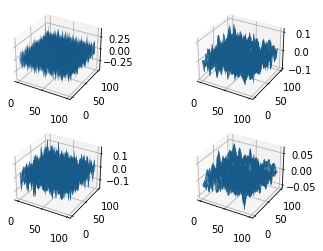

In [1]:
import numpy as np
# https://raw.githubusercontent.com/sadimanna/savitzky_golay/master/savgol2D.py
def savgol2Dcoeff(order=2,npx=5,npy=5):
	#Y = SUM(SUM(aij*v^i*w^j))
	#Since in an image x is taken to be the vertical direction and y is the horizontal direction, we will transform the variable x into w and y into v, contrary to the convention
	v = np.arange(-(npy-1)/2,((npy+1)/2))
	w = np.arange(-(npx-1)/2,((npx+1)/2))
	#Jacobian
	#Calculating the number of elements in each row
	numval = sum(n+1 for n in range(order+1))
	#declaring Jacobian as an empty matrix 
	J = np.empty([0,numval])
	#computing the jacobian Matrix
	for val_w in w:
		for val_v in v:
			Jrow = []
			order_done = []
			for o in range(order+1):
				for j in range(o+1):
					for i in range(o+1):
						Jrow_val = (val_v**i)*(val_w**j)
						if i+j == o and o not in order_done:
							Jrow.append(Jrow_val)
				order_done.append(o)
			#print Jrow
			J = np.vstack((J,Jrow))
	
	JT = np.transpose(J)
	JTJ = np.matmul(JT,J)
	iJTJ = np.linalg.inv(JTJ)
	C = np.matmul(iJTJ,JT)
	return C

def savgol2Dfilt(data2D,order=2,npx=5,npy=5,h=2):
	savgolcoeff = savgol2Dcoeff(order,npx,npy)
	#Since we need only the coeff a00
	coeff = savgolcoeff[0,:].reshape((npx,npy))
	#padding the original data for taking the boundary values
	padx_len = int(h*(npx-1)/2)
	pady_len = int(h*(npy-1)/2)
	half_xwin = padx_len
	half_ywin = pady_len
	data_pad  = np.pad(data2D,((padx_len,padx_len),(pady_len,pady_len)),'constant',constant_values=(0,0))
	data_shape = data2D.shape
	data_pad_shape = data_pad.shape
	new_data = np.zeros(data_shape)
	for i in range(padx_len,data_pad_shape[0]-padx_len):
		for j in range(pady_len,data_pad_shape[1]-pady_len):
			data_window = data_pad[i-half_xwin:i+half_xwin+1,j-half_ywin:j+half_ywin+1]
			new_data[i-padx_len,j-pady_len] = np.sum(np.multiply(data_window,coeff))
	return new_data


#Test Smoothing filter
import mpl_toolkits.mplot3d as p3
import matplotlib.pyplot as plt
fig = plt.figure()
X,Y = np.meshgrid(np.arange(100),np.arange(100))
s = np.random.normal(0,0.1,(100,100))
snew = savgol2Dfilt(s,2,7,7,1)
snew2 = savgol2Dfilt(s,2,5,5,1)
snew3 = savgol2Dfilt(s,2,11,11,1)
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.plot_surface(X,Y,s)
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.plot_surface(X,Y,snew)
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.plot_surface(X,Y,snew2)
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.plot_surface(X,Y,snew3)
plt.show()

In [48]:
import cv2
im = cv2.imread(r'C:\Users\franc\PVcharacterization_files\EL\intensity_normalzed\Panasonic_W3AKSNH15247_600mA_6000ms.tif',
               cv2.IMREAD_UNCHANGED)
im.max()

36957

In [49]:
im.shape

(2896, 2048)

In [38]:
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
image = image.imread(r'C:\Users\franc\PVcharacterization_files\EL\intensity_normalzed\Panasonic_W3AKSNH15247_600mA_6000ms.tif')


AttributeError: 'numpy.ndarray' object has no attribute 'show'

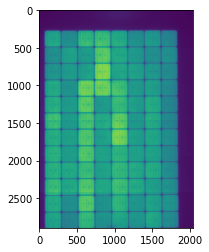

In [50]:
plt.imshow(im[::-1,:])

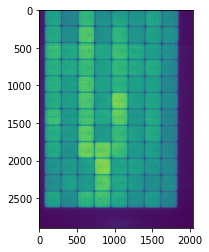

In [51]:
plt.imshow(im[::-1,:])